#### Axel & Tristan

In [1]:
# Packages
using Flux
using Zygote
using MLDatasets
using LinearAlgebra
using Plots
using LaTeXStrings

In [6]:

h = 3  # Final number of hidden layers
nodes = [100, 200, 500, 1000]  # Number of nodes in each hidden layer

# Initialize arrays to hold models
models_S = [] # sigmoid activation function
models_R = [] # ReLu activation function

for i in 1:h
    layers_S = []
    layers_R = []

    # Input to first hidden layer
    push!(layers_S, Dense(1 => n[i], σ))
    push!(layers_R, Dense(1 => n[i], relu))

    # Additional hidden layers
    for j in 2:i
        push!(layers_S, Dense(n[j] => n[j], σ))
        push!(layers_R, Dense(n[j] => n[j], relu))
    end

    # Output layer
    push!(layers_S, Dense(n[i] => 1))
    push!(layers_R, Dense(n[i] => 1))

    # Construct the models
    model_i_S = Chain(layers_S...)|> f64 # Here we use Float64 instead of the typical Float32 
    model_i_R = Chain(layers_R...)|> f64 # It's not possible to get more precison with Flux models

    # Store the models
    push!(models_S, model_i_S)
    push!(models_R, model_i_R)
end

display(models_S)
display(models_R)
typeof(models_S[1])


model1  = models_S[1] # 1->100->100->1 (Sigmoid)
model





UndefVarError: UndefVarError: `n` not defined

In [44]:

# Function to create a model
function create_model(Ni, Nh, No, N, activation)
    layers = [] # Initialize an empty array without specifying the type of elements
    push!(layers, Dense(Ni, N, activation)) # First hidden layer with N nodes and specified activation
    for _ in 2:Nh
        push!(layers, Dense(N, N, activation)) # Additional Nh-1 hidden layers
    end
    push!(layers, Dense(N, No)) # Output layer without specifying an activation function (defaults to identity)
    model = Chain(layers...)|>f64 # Create the model from the layers
    return model
end

# Example usage
Ni = 1 # Dimension of input
No = 1 # Dimension of output
Nhidden = 1 # Number of hidden layers
Nh_nodes = 40 # Number of nodes in each hidden layer
activation = relu # Sigmoid activation function for hidden layers

model = create_model(Ni, Nhidden, No, Nh_nodes, activation)


# Display the models
display(model)


Chain(
  Dense(1 => 40, relu),                 # 80 parameters
  Dense(40 => 1),                       # 41 parameters
)                   # Total: 4 arrays, 121 parameters, 1.195 KiB.

In [38]:
### Training

tMax=pi/2
Nt=Int(50)
tVec=collect(((range(start=0.0,stop=tMax,length=Nt)).^2)')
x1Vec= cos.(tVec).^2

# loss(yM, y) = Flux.Losses.mse(yM,y)

# # opt_state = Flux.setup(Adam(0.00003), model1)
# opt_state = Flux.setup(Descent(0.0005), model1)
# data1 = [(tVec, x1Vec)]

# println("loss before=",loss(model(tVec),x1Vec))

# for epoch in 1:50
#     Flux.train!(model, data1, opt_state) do m, x, y
#         loss(m(x), y)
#     end
# end
# println("loss after=",loss(model(tVec),x1Vec))



1×50 Matrix{Float64}:
 1.0  0.999999  0.999983  0.999914  0.99973  …  0.414322  0.511523  0.610292

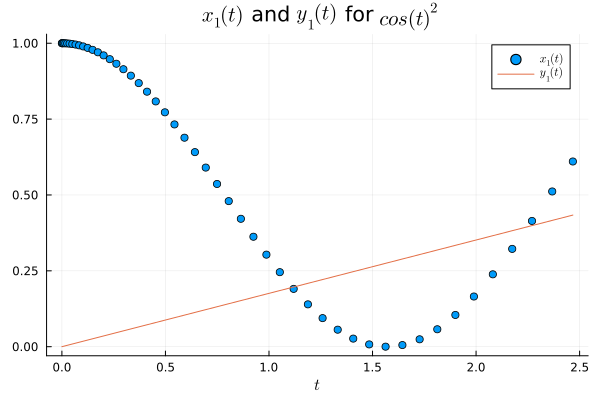

In [45]:
scatter(tVec',x1Vec',label=L"$x_1(t)$")
plot!(tVec',model(tVec)',label=L"$y_1(t)$")
plot!(xlabel=L"$t$",title=L" $x_1(t)$ and $y_1(t)$ for $cos(t)^2$")
# display(tVec)
# display(model1)

In [3]:
input_dim = 3
Nh = 100
output_dim = 3
model1 = Chain(Dense(input_dim=>Nh, σ), Dense(Nh=>output_dim))|>f64


Chain(
  Dense(3 => 100, σ),                   # 400 parameters
  Dense(100 => 3),                      # 303 parameters
)                   # Total: 4 arrays, 703 parameters, 5.742 KiB.

In [46]:
function kernel(model, x, Nh)
    """
    This function computes the "Kernel" of a given neural network
    """
    n = length(x)
    K = zeros(Float64,n, n)  # Initialize empty Kernel
   
    
    gs = xi-> Flux.gradient(() -> model([xi])[1],Flux.params(model)) # anonymous function
    all_grads = []
    
    # Collect numerical values
    for i in 1:n
        current_grad = []
        for j in 1:length(Flux.params(model))
            push!(current_grad, gs(x[i])[Flux.params(model)[j]])
        end
        current_grad = collect(Iterators.flatten(current_grad)) # flatten
        push!(all_grads, current_grad)
    end

    # Evaluate each K[i,j]
    for i = 1:n
        for j = 1:n
            K[i,j] = all_grads[i]'*all_grads[j] # ' means transposed
        end
    end

    return K
end




K = kernel(model, tVec, Nh_nodes)
λ = eigen(K).values

# small_λ = []
# for i in range(1, length=length(λ))
#     if  λ[i] < 1.0*10^(-15)
#         push!(small_λ, λ[i])
#     end
# end

# display(small_λ)

λ

 

50-element Vector{Float64}:
  -7.105427357601002e-15
  -5.329070518200751e-15
  -3.552713695131945e-15
  -3.552713678800501e-15
  -2.220446049250313e-15
  -2.220446049250313e-15
  -2.1232193625326375e-15
  -1.7763568394002505e-15
  -1.7763568394002505e-15
  -1.3521012530317271e-15
   ⋮
   1.7763568394002505e-15
   1.7763568394002505e-15
   2.6645352591003757e-15
   3.1086244689504383e-15
   3.552713678800501e-15
   2.035322194676901e-14
   0.4726699165799907
  25.798948045530864
 179.761632892254

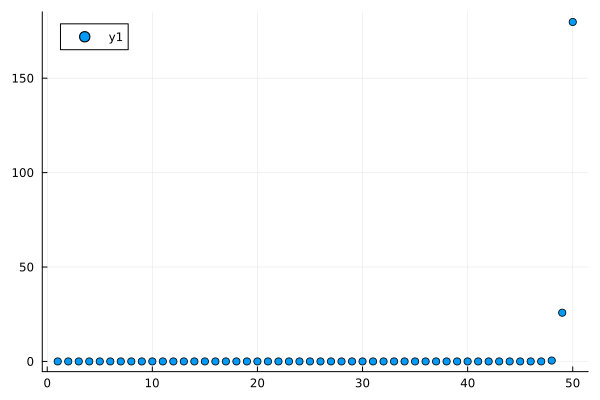

In [47]:
scatter(1:length(λ),λ)

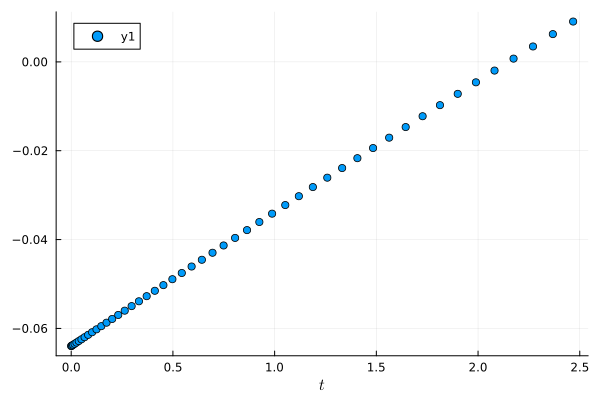

In [13]:
function df(K,model,x,y)
    fθ = model1(x)
    
    Δ = K*(fθ-y)'

    return Δ
end




Δ = df(K,model1,tVec,x1Vec)

scatter(tVec',Δ)
plot!(xlabel=L"$t$")


In [14]:
function dθ_dt(K,x,y)
    θ_list = []
    for i in 1:length(x)
            
        push!(θ_list, K[i,:]*(x[i]-x1Vec[i]))
        
    end
    dθ = -sum(θ_list)
   return dθ
end


x = model1(tVec)

Δθ = dθ_dt(K,x,x1Vec)

50-element Vector{Float64}:
  0.0639674349852965
  0.06393631167787883
  0.06384294173105128
  0.06368732511647379
  0.06346946193821942
  0.06318935265972901
  0.06284699842154164
  0.06244240144978271
  0.06197556555537559
  0.0614464967239096
  ⋮
  0.012232126494348683
  0.009739017890417024
  0.0071948435251893116
  0.004600652830604356
  0.0019575603253334413
 -0.0007332530433211276
 -0.0034705387396544093
 -0.006252979679364834
 -0.009079189486325804

In [4]:

# t is a 3-vector representing a 3-dimensional datapoint in space
# we create 3 t vectors
t1 = [1;-1;2]
t2 = [2;1;-1]
t3 = [1;1;1] 

t1 = Float64.(t1)
t2 = Float64.(t2)
t3 = Float64.(t3)
# the dimension of the kernel-matrix for 1-dimensional datapoints is nxn (where n is number of datapoints)
# the dimension of the kernel-matrix for m-dimensional datapoints is n(mxm)
# to train them all together we would create a T-matrix = [t1 t2 t3]

T = hcat(t1,t2,t3)    # matrix containing all m-dimensionl-datapoints
m = size(T)[1] # number of dimensions 
n = size(T)[2] # number of datapoints
nodes = 10 # number of nodes in hidden layers/layer

# we create a simple model to that works with the 3-dimensional datapoints 
model = Chain(
    Dense(m=>nodes,sigmoid),
    Dense(nodes=>m)
)|>f64


# we collect all parameters
θ_NoFlat = Flux.params(modelM)
# # Initialize an empty array to store the flattened parameters
# θ = []

# Iterate through each parameter in θ_NoFlat
# for param in θ_NoFlat
#     # Flatten the parameter and append it to θ_flat
#     append!(θ, param[:])
# end



# gs = t_i -> Flux.gradient(() -> modelM(t_i),θ_NoFlat)

# # Calculate gradients for t1
# grads = gs(t1)



Params([[-0.27938440442085266 0.3757745325565338 -0.2005033940076828; -0.38221728801727295 0.4155992269515991 -0.4483652412891388; … ; 0.589454174041748 0.6207812428474426 -0.5870744585990906; -0.2544395923614502 0.39358362555503845 -0.04890580102801323], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5441858172416687 0.5121151804924011 … -0.49140793085098267 -0.4761628210544586; -0.17001624405384064 -0.06377942860126495 … 0.5129303336143494 0.5377639532089233; -0.16874928772449493 0.258235365152359 … -0.061983220279216766 -0.04346794635057449], [0.0, 0.0, 0.0]])

In [1]:
model = Chain(Dense(2,2),Dense(2,2))

Flux.params(model)[1] .= ones(Float64,2,2)
Flux.params(model)[2] .= Float64.([1;0])
Flux.params(model)[3] .= ones(Float64,2,2)*2
Flux.params(model)[4] .= Float64.([0;1])

W1 = Flux.params(model)[1]
B1 = Flux.params(model)[2]
W2 = Flux.params(model)[3]
B2 = Flux.params(model)[4]



# for i in 1:4 
#     display(Flux.params(model)[i])
# end


t1 = [1;0]
t2 = [2;1]




function df_1(W1,B1,W2,B2,t)
    df_dθ1 = Float64.([W2[1,1]*t[1]; W2[2,1]*t[1]])
    return df_dθ1
end
function df_2(W1,B1,W2,B2,t)
    df_dθ2 = Float64.([W2[1,2]*t[1]; W2[2,2]*t[1]])
    return df_dθ2
end
function df_3(W1,B1,W2,B2,t)
    df_dθ3 = Float64.([W2[1,1]*t[2]; W2[2,1]*t[2]])
    return df_dθ3
end
function df_4(W1,B1,W2,B2,t)
    df_dθ4 = Float64.([W2[1,1]*t[2]; W2[2,1]*t[2]])
    return df_dθ4
end
function df_5(W1,B1,W2,B2,t)
    df_dθ5 = Float64.([W2[1,1];W2[2,1]])
    return df_dθ5
end
function df_6(W1,B1,W2,B2,t)
    df_dθ6 = Float64.([W2[1,2];W2[2,2]])
    return df_dθ6
end
function df_7(W1,B1,W2,B2,t)
    df_dθ7 = Float64.([W1[1,1]*t[1]+B1[1]+W1[1,2]*t[2];0])
    return df_dθ7
end
function df_8(W1,B1,W2,B2,t)
    df_dθ8 = Float64.([0;W1[1,1]*t[1]+B1[1]+W1[1,2]*t[2]])
    return df_dθ8
end
function df_9(W1,B1,W2,B2,t)
    df_dθ9 = Float64.([W1[2,1]*t[1]+B1[2]+W1[2,2]*t[2];0])
    return df_dθ9
end
function df_10(W1,B1,W2,B2,t)
    df_dθ10 = Float64.([0;W1[2,1]*t[1]+B1[2]+W1[2,2]*t[2]])
    return df_dθ10
end
function df_11(W1,B1,W2,B2,t)
    df_dθ11 = Float64.([1;0])
    return df_dθ11
end
function df_12(W1,B1,W2,B2,t)
    df_dθ12 = Float64.([0;1])
    return df_dθ12
end

# Collect all the derivative functions in an array for easier iteration
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12]

# Initialize a structure to hold the results
results_t1 = zeros(Float64, 12, 2)
results_t2 = zeros(Float64, 12, 2)

# Compute derivatives for t1 and t2
for (i, df) in enumerate(dfs)
    results_t1[i, :] = df(W1, B1, W2, B2, t1)
    results_t2[i, :] = df(W1, B1, W2, B2, t2)
end

# block 11
K11 = results_t1'*results_t1

# block 12
K12 = results_t1'*results_t2

# block 21
K21 = results_t2'*results_t1

# block 22
K22 = results_t2'*results_t2

K = [K11 K12;K21 K22]



K = K/sqrt(2)

λ = eigen(K).values


UndefVarError: UndefVarError: `Dense` not defined

In [20]:
include("NTKernel.jl")

kernel (generic function with 1 method)

In [44]:
x_train = hcat(t1,t2)
Kernel = kernel(model,x_train)/sqrt(2)
λ = eigen(Kernel).values


4-element Vector{Float64}:
   0.26834748179749995
   4.780512990027586
  22.35906951617198
 108.35657199981989

In [35]:
using Flux

# Define the model
model = Chain(Dense(2, 2, σ), Dense(2, 2))

# Initialize model parameters
Flux.params(model)[1] .= ones(Float64, 2, 2)  # W1
Flux.params(model)[2] .= Float64.([1, 0])     # B1
Flux.params(model)[3] .= ones(Float64, 2, 2) * 2  # W2
Flux.params(model)[4] .= Float64.([0, 1])     # B2

# Input tensors
t1 = [1; 0]
t2 = [2; 1]

# Function to compute the gradients of model output with respect to its parameters
function model_grads(model, t)
    grads = gradient(() -> sum(model(t)), Flux.params(model))
    return vcat([grads[p] for p in Flux.params(model)]...)  # Flatten and concatenate gradients
end

# Compute and flatten gradients for t1 and t2
grads_t1 = model_grads(model, t1)  # This will be a vector
grads_t2 = model_grads(model, t2)  # This will be a vector

# Assemble the gradient matrix for both inputs
gradient_matrix = [grads_t1 grads_t2]

# Compute the kernel matrix by multiplying the gradient matrix with its transpose
K = gradient_matrix' * gradient_matrix

# Normalize K
K_normalized = K / sqrt(2)

# Compute eigenvalues
eigenvalues = eigen(K_normalized).values

K_normalized, eigenvalues


ArgumentError: ArgumentError: number of columns of each array must match (got (2, 1, 2, 1))

In [123]:



tTest = [1;0]

θ = Flux.params(model)


f = Float64.(θ[1]*t1+θ[2])

# Loop over the number of hidden layers
for n in 1:Nh
    global f
    
    f = θ[2n+1] * f + θ[2n+2]
end

display(f)


display(model(tTest))






2-element Vector{Float64}:
 6.0
 7.0

2-element Vector{Float64}:
 3.223711313215775
 4.223711313215775